In [1]:
using BSON: @load
using Flux
using Flux: chunk
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots
using Zygote
using FFTW
using Distributions
using SparseArrays

Consider the denoising problem of recovering $x\in\mathbb{R}^n$ from noisy measurements of the form

$$y = A(x) + \epsilon, $$

where $\epsilon\in\mathbb{R}^n$ is noise. We assume the unknown signal $x$ lives in the range of known generative model $G:\mathbb{R}^k \rightarrow \mathbb{R}^n$, i.e. $x = G(z)$ for some $z \in \mathbb{R}^k$. We assume the generative model $G$ is  fully-connected feedforward network of the form 

$$ G(x) = \sigma_d(A_d\sigma_{d-1}(A_{d-1} \cdots \sigma_1(A_1 z)\cdots)),$$

where $A_i \in \mathbb{R}^{n_i \times n_{i-1}}$ is the weight matrix and $\sigma_i$ is the activation function correpsonding to the $i\text{th}$ layer of $G$. Thus, the task of recovering $x$ can be reduced to recovering the corresponding $z$ such that $G(z) = x$. 


We solve this problem using the following iterative algorithm called Partially Linearized Updates for Generative Inversion (PLUGIn):

$$x^{k+1} = x^k -\eta A_1^{\top}\cdots A_d^{\top}A^\top\left(AG(x^k) - y \right) .$$

Here, $\eta$ is the stepsize that depends on the weight matrices and the activation functions. This algorithm is implemented below:



In [2]:
# output the plugin Iterate
function PLUGIN_denoise(G, W, A, y, z, stepsize)
    d = W'* (A'*(A*G(z) - y ))
    return z - stepsize * d
end

# output the plugin Iterate
function PLUGIN_denoise_regularized(G, W, A, y, z, stepsize, λ)
    d = W'* (A'*(A*G(z) - y )) + 2*λ*z  
    return z - stepsize * d
    println("1")
end

# output the plugin Iterate
function PLUGIN_denoise_normalized(G, W, A, y, z, stepsize, scale)
    d = W'* (A'*(A*G(z) - y))
    return (z - stepsize * d) * scale / norm(z - stepsize * d,2)
end

# output the plugin Iterate
function proj(z, scale)
    if norm(z) > scale
        z = scale * z/norm(z)
    end
    return z
end


function relative_error(x_true, x_estimate)
    return norm(x_true - x_estimate)/norm(x_true)
end

relative_error (generic function with 1 method)

One advantage of PLUGIn algorithm in general is that it allows us to pre-multiply the weight matrices. The following function is used to compute $A_d\cdot A_{d-1}\cdots A_1$ given a generative model $G$. It also normalizes each weight matrix w.r.t. its top singular value.

In [3]:
function normalized_weight_product(G)
    (_, z_dim) = size(Flux.params(G[1])[1]);
    W = I(z_dim)
    for i in 1:length(G)
        _, s, _ = svd(Flux.params(G[i])[1])
        W = Flux.params(G[i])[1] * W /(s[1]^2)
    end
    return W
end  

normalized_weight_product (generic function with 1 method)

In [4]:
function create_network(net_param)
    n_0 = net_param[1]
    n_1 = net_param[2]
    L = Chain(Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))

    for i in 2:length(net_param)-1
        n_0 = net_param[i]
        n_1 = net_param[i+1]
        L = Chain(L, Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))
    end
    return L
end

create_network (generic function with 1 method)

In [70]:
#########  SNR  #################
max_iter = 1000
stepsize_PLUGIn = .5
stepsize_GD = .5
noise_level_list = 0:.1:1
trials = 10

m = 500

recov_error_matrix_PLUGIn = zeros(length(noise_level_list))
recon_error_matrix_PLUGIn = zeros(length(noise_level_list))

recov_error_matrix_GD = zeros(length(noise_level_list))
recon_error_matrix_GD = zeros(length(noise_level_list))

recov_error_matrix_PLUGIn_proj = zeros(length(noise_level_list))
recon_error_matrix_PLUGIn_proj = zeros(length(noise_level_list))

recov_error_matrix_GD_proj = zeros(length(noise_level_list))
recon_error_matrix_GD_proj = zeros(length(noise_level_list))

recov_error_matrix_PLUGIn_reg = zeros(length(noise_level_list))
recon_error_matrix_PLUGIn_reg = zeros(length(noise_level_list))

recov_error_matrix_GD_reg = zeros(length(noise_level_list))
recon_error_matrix_GD_reg = zeros(length(noise_level_list))

net_param = [70, 200, 750]
G = create_network(net_param)
W = normalized_weight_product(G)

depth = length(Flux.params(G)) / 2

(_, z_dim) = size(Flux.params(G)[1]);
(x_dim, _) = size(Flux.params(G)[Int(depth*2 - 1)])


for trial in 1:trials

    
    A = randn(m, 750) / sqrt(m)
    recov_error_PLUGIn = []
    recon_error_PLUGIn = []

    recov_error_GD = []
    recon_error_GD = []

    recov_error_PLUGIn_proj = []
    recon_error_PLUGIn_proj = []

    recov_error_GD_proj = []
    recon_error_GD_proj = []

    recov_error_PLUGIn_reg = []
    recon_error_PLUGIn_reg = []

    recov_error_GD_reg = []
    recon_error_GD_reg = []

    z = randn(z_dim)
    z = z/norm(z) #unit sphere

    for noise_level in noise_level_list
        noise_temp = randn(m)
        y = A*G(z) + noise_level * noise_temp/norm(noise_temp)

        descent(z) = gradient(z->norm(A*G(z) - y,2)^2, z)[1]   
        descent_regularized(z, λ) = gradient(z->norm(A*G(z) - y,2)^2 +λ*norm(z,2)^2, z)[1]        

        z_est_PLUGIn = randn(z_dim)
        z_est_GD = randn(z_dim)

        z_est_PLUGIn_proj = randn(z_dim)
        z_est_GD_proj = randn(z_dim)

        z_est_PLUGIn_reg = randn(z_dim)
        z_est_GD_reg = randn(z_dim)

        iter = 1
        for iter in 1:max_iter

            z_est_PLUGIn = PLUGIN_denoise(G, W, A, y, z_est_PLUGIn, stepsize_PLUGIn)
            d = descent(z_est_GD); z_est_GD -= stepsize_GD *d

            z_est_PLUGIn_proj = PLUGIN_denoise(G, W, A, y, z_est_PLUGIn_proj, stepsize_PLUGIn)
            z_est_PLUGIn_proj = proj(z_est_PLUGIn_proj, 1)

            d = descent(z_est_GD_proj); z_est_GD_proj -= stepsize_GD *d; z_est_GD_proj = proj(z_est_GD_proj, 1)

            z_est_PLUGIn_reg = PLUGIN_denoise_regularized(G, W, A, y, z_est_PLUGIn_reg, stepsize_PLUGIn, 0.05)

            d = descent_regularized(z_est_GD_reg, 0.05); z_est_GD_reg -= stepsize_GD *d

        end
 
        push!(recov_error_PLUGIn, relative_error(z, z_est_PLUGIn))
        push!(recon_error_PLUGIn,  relative_error(G(z), G(z_est_PLUGIn)) )

        push!(recov_error_GD, relative_error(z, z_est_GD))
        push!(recon_error_GD, relative_error(G(z), G(z_est_GD)) )  

        push!(recov_error_PLUGIn_proj, relative_error(z, z_est_PLUGIn_proj))
        push!(recon_error_PLUGIn_proj,  relative_error(G(z), G(z_est_PLUGIn_proj)) )

        push!(recov_error_GD_proj, relative_error(z, z_est_GD_proj))
        push!(recon_error_GD_proj, relative_error(G(z), G(z_est_GD_proj)) )  

        push!(recov_error_PLUGIn_reg, relative_error(z, z_est_PLUGIn_reg))
        push!(recon_error_PLUGIn_reg,  relative_error(G(z), G(z_est_PLUGIn_reg)) )

        push!(recov_error_GD_reg, relative_error(z, z_est_GD_reg))
        push!(recon_error_GD_reg, relative_error(G(z), G(z_est_GD_reg)) )  
    end

    recov_error_matrix_PLUGIn = hcat(recov_error_matrix_PLUGIn, recov_error_PLUGIn)
    recon_error_matrix_PLUGIn =  hcat(recon_error_matrix_PLUGIn, recon_error_PLUGIn)

    recov_error_matrix_GD = hcat(recov_error_matrix_GD, recov_error_GD)
    recon_error_matrix_GD = hcat(recon_error_matrix_GD, recon_error_GD)

    recov_error_matrix_PLUGIn_proj = hcat(recov_error_matrix_PLUGIn_proj, recov_error_PLUGIn_proj)
    recon_error_matrix_PLUGIn_proj =  hcat(recon_error_matrix_PLUGIn_proj, recon_error_PLUGIn_proj)

    recov_error_matrix_GD_proj = hcat(recov_error_matrix_GD_proj, recov_error_GD_proj)
    recon_error_matrix_GD_proj = hcat(recon_error_matrix_GD_proj, recon_error_GD_proj)

    recov_error_matrix_PLUGIn_reg = hcat(recov_error_matrix_PLUGIn_reg, recov_error_PLUGIn_reg)
    recon_error_matrix_PLUGIn_reg =  hcat(recon_error_matrix_PLUGIn_reg, recon_error_PLUGIn_reg)

    recov_error_matrix_GD_reg = hcat(recov_error_matrix_GD_reg, recov_error_GD_reg)
    recon_error_matrix_GD_reg = hcat(recon_error_matrix_GD_reg, recon_error_GD_reg)

end


# save("result/talk/CS_error_denoise_recov.jld", "error_GD", recov_error_matrix_GD, "error_PLUGIn", recov_error_matrix_PLUGIn, "error_GD_proj", recov_error_matrix_GD_proj, "error_PLUGIn_proj", recov_error_matrix_PLUGIn_proj, "error_GD_reg", recov_error_matrix_GD_reg, "error_PLUGIn_reg", recov_error_matrix_PLUGIn_reg)
# save("result/talk/CS_error_denoise_recon.jld", "error_GD", recon_error_matrix_GD, "error_PLUGIn", recon_error_matrix_PLUGIn, "error_GD_proj", recon_error_matrix_GD_proj, "error_PLUGIn_proj", recon_error_matrix_PLUGIn_proj, "error_GD_reg", recon_error_matrix_GD_reg, "error_PLUGIn_reg", recon_error_matrix_PLUGIn_reg)


In [71]:

save("result/talk/CS_results/CS_error_denoise_recov_low_ratio.jld", "error_GD", recov_error_matrix_GD, "error_PLUGIn", recov_error_matrix_PLUGIn, "error_GD_proj", recov_error_matrix_GD_proj, "error_PLUGIn_proj", recov_error_matrix_PLUGIn_proj, "error_GD_reg", recov_error_matrix_GD_reg, "error_PLUGIn_reg", recov_error_matrix_PLUGIn_reg)
save("result/talk/CS_results/CS_error_denoise_recon_low_ratio.jld", "error_GD", recon_error_matrix_GD, "error_PLUGIn", recon_error_matrix_PLUGIn, "error_GD_proj", recon_error_matrix_GD_proj, "error_PLUGIn_proj", recon_error_matrix_PLUGIn_proj, "error_GD_reg", recon_error_matrix_GD_reg, "error_PLUGIn_reg", recon_error_matrix_PLUGIn_reg)


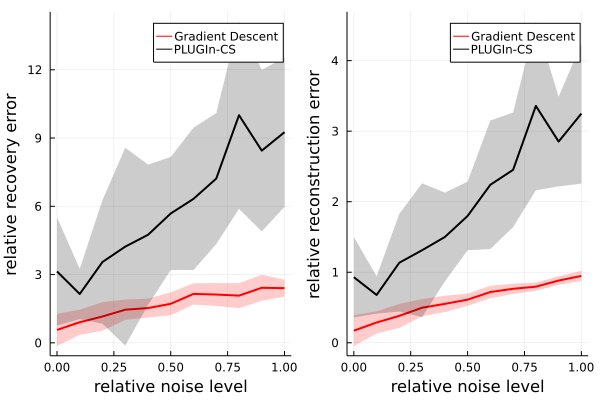

In [72]:
average_recov = mean(recov_error_matrix_GD[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_GD[:, 2:end], dims=2)
plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recov, label = "Gradient Descent", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, color =:red)

average_recov = mean(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, c =:black, label = false, linecolor = invisible())
p1 = plot!(noise_level_list, average_recov, label = "PLUGIn-CS", xlabel = "relative noise level", ylabel = "relative recovery error", linewidth = 2, color =:black )


#################################################################################
average_recon = mean(recon_error_matrix_GD[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_GD[:, 2:end], dims=2)
plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = .2, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recon, label = "Gradient Descent", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2, c =:red)


average_recon = mean(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .2, c =:black, label = false, linecolor = invisible())
p2 = plot!(noise_level_list, average_recon, label = "PLUGIn-CS", xlabel = "relative noise level", ylabel = "relative reconstruction error", linewidth = 2 , c =:black)


plot(p1, p2, layout = (1,2))

savefig("result/talk/CS_results/CS_original_noise_low_ratio.pdf")
plot(p1, p2, layout = (1,2))


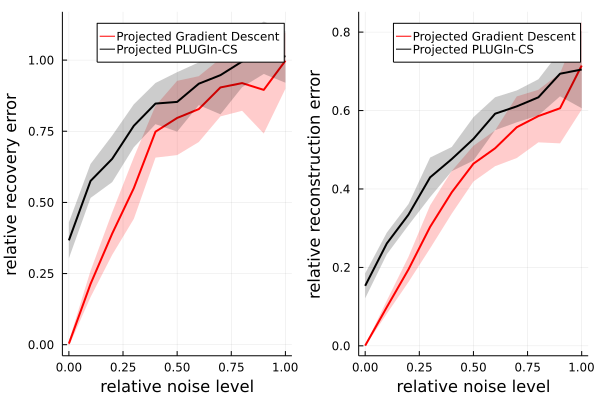

In [73]:

average_recov = mean(recov_error_matrix_GD_proj[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_GD_proj[:, 2:end], dims=2)
plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recov, label = "Projected Gradient Descent", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, color =:red)

average_recov = mean(recov_error_matrix_PLUGIn_proj[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_PLUGIn_proj[:, 2:end], dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, c =:black, label = false, linecolor = invisible())
p1 = plot!(noise_level_list, average_recov, label = "Projected PLUGIn-CS", xlabel = "relative noise level", ylabel = "relative recovery error", linewidth = 2, color =:black )


#################################################################################
average_recon = mean(recon_error_matrix_GD_proj[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_GD_proj[:, 2:end], dims=2)
plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = .2, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recon, label = "Projected Gradient Descent", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2, c =:red)


average_recon = mean(recon_error_matrix_PLUGIn_proj[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_PLUGIn_proj[:, 2:end], dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .2, c =:black, label = false, linecolor = invisible())
p2 = plot!(noise_level_list, average_recon, label = "Projected PLUGIn-CS", xlabel = "relative noise level", ylabel = "relative reconstruction error", linewidth = 2 , c =:black)

plot(p1, p2, layout = (1,2))
savefig("result/talk/CS_results/CS_proj_noise_low_ratio.pdf")
plot(p1, p2, layout = (1,2))


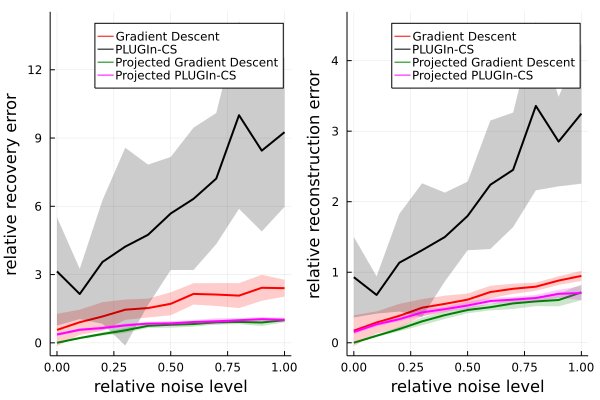

In [74]:
average_recov = mean(recov_error_matrix_GD[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_GD[:, 2:end], dims=2)
plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recov, label = "Gradient Descent", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, color =:red)

average_recov = mean(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, c =:black, label = false, linecolor = invisible())
plot!(noise_level_list, average_recov, label = "PLUGIn-CS", xlabel = "relative noise level", ylabel = "relative recovery error", linewidth = 2, color =:black )


average_recov = mean(recov_error_matrix_GD_proj[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_GD_proj[:, 2:end], dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, color =:green, label = false, linecolor = invisible())
plot!(noise_level_list, average_recov, label = "Projected Gradient Descent", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, color =:green)

average_recov = mean(recov_error_matrix_PLUGIn_proj[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_PLUGIn_proj[:, 2:end], dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, c =:magenta, label = false, linecolor = invisible())
p1 = plot!(noise_level_list, average_recov, label = "Projected PLUGIn-CS", xlabel = "relative noise level", ylabel = "relative recovery error", linewidth = 2, color =:magenta )


#################################################################################
average_recon = mean(recon_error_matrix_GD[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_GD[:, 2:end], dims=2)
plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = .2, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recon, label = "Gradient Descent", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2, c =:red)


average_recon = mean(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .2, c =:black, label = false, linecolor = invisible())
plot!(noise_level_list, average_recon, label = "PLUGIn-CS", xlabel = "relative noise level", ylabel = "relative reconstruction error", linewidth = 2 , c =:black)

average_recon = mean(recon_error_matrix_GD_proj[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_GD_proj[:, 2:end], dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = .2, color =:green, label = false, linecolor = invisible())
plot!(noise_level_list, average_recon, label = "Projected Gradient Descent", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2, c =:green)


average_recon = mean(recon_error_matrix_PLUGIn_proj[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_PLUGIn_proj[:, 2:end], dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .2, c =:magenta, label = false, linecolor = invisible())
p2 = plot!(noise_level_list, average_recon, label = "Projected PLUGIn-CS", xlabel = "relative noise level", ylabel = "relative reconstruction error", linewidth = 2 , c =:magenta)

plot(p1, p2, layout = (1,2))
savefig("result/talk/CS_results/CS_comparison_low_ratio.pdf")
plot(p1, p2, layout = (1,2))

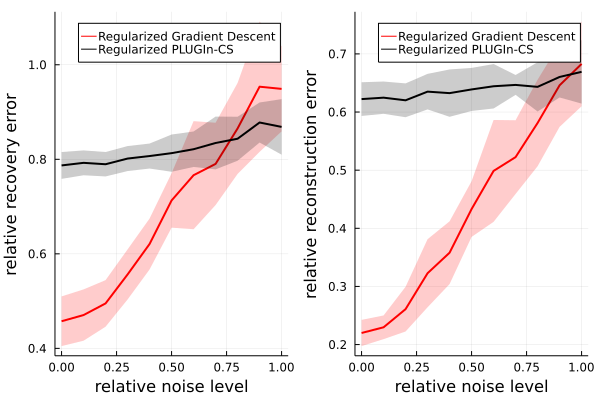

In [75]:

average_recov = mean(recov_error_matrix_GD_reg[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_GD_reg[:, 2:end], dims=2)
plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recov, label = "Regularized Gradient Descent", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, color =:red)

average_recov = mean(recov_error_matrix_PLUGIn_reg[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_PLUGIn_reg[:, 2:end], dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, c =:black, label = false, linecolor = invisible())
p1 = plot!(noise_level_list, average_recov, label = "Regularized PLUGIn-CS", xlabel = "relative noise level", ylabel = "relative recovery error", linewidth = 2, color =:black )


#################################################################################
average_recon = mean(recon_error_matrix_GD_reg[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_GD_reg[:, 2:end], dims=2)
plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = .2, color =:red, label = false, linecolor = invisible())
plot!(noise_level_list, average_recon, label = "Regularized Gradient Descent", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2, c =:red)


average_recon = mean(recon_error_matrix_PLUGIn_reg[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_PLUGIn_reg[:, 2:end], dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .2, c =:black, label = false, linecolor = invisible())
p2 = plot!(noise_level_list, average_recon, label = "Regularized PLUGIn-CS", xlabel = "relative noise level", ylabel = "relative reconstruction error", linewidth = 2 , c =:black)


plot(p1, p2, layout = (1,2))


savefig("result/talk/CS_results/CS_reg_noise_low_ratio.pdf")
plot(p1, p2, layout = (1,2))


In [76]:
############ MEASUREMENTS ###############
max_iter = 1200
stepsize_PLUGIn = .75
noise_level_list = 0:.02:.12
trials = 10

m_list = 80:10:550

recov_error_matrix_PLUGIn_0 = zeros(length(m_list))
recon_error_matrix_PLUGIn_0 = zeros(length(m_list))

recov_error_matrix_PLUGIn_2 = zeros(length(m_list))
recon_error_matrix_PLUGIn_2 = zeros(length(m_list))

recov_error_matrix_PLUGIn_4 = zeros(length(m_list))
recon_error_matrix_PLUGIn_4 = zeros(length(m_list))

recov_error_matrix_PLUGIn_6 = zeros(length(m_list))
recon_error_matrix_PLUGIn_6 = zeros(length(m_list))

recov_error_matrix_PLUGIn_8 = zeros(length(m_list))
recon_error_matrix_PLUGIn_8 = zeros(length(m_list))
#############################
recov_error_matrix_PLUGIn_10_proj = zeros(length(m_list))
recon_error_matrix_PLUGIn_10_proj = zeros(length(m_list))

recov_error_matrix_PLUGIn_0_proj = zeros(length(m_list))
recon_error_matrix_PLUGIn_0_proj = zeros(length(m_list))

recov_error_matrix_PLUGIn_2_proj = zeros(length(m_list))
recon_error_matrix_PLUGIn_2_proj = zeros(length(m_list))

recov_error_matrix_PLUGIn_4_proj = zeros(length(m_list))
recon_error_matrix_PLUGIn_4_proj = zeros(length(m_list))

recov_error_matrix_PLUGIn_6_proj = zeros(length(m_list))
recon_error_matrix_PLUGIn_6_proj = zeros(length(m_list))

recov_error_matrix_PLUGIn_8_proj = zeros(length(m_list))
recon_error_matrix_PLUGIn_8_proj = zeros(length(m_list))

recov_error_matrix_PLUGIn_10_proj = zeros(length(m_list))
recon_error_matrix_PLUGIn_10_proj = zeros(length(m_list))

net_param = [20, 200, 750]
G = create_network(net_param)
W = normalized_weight_product(G)
depth = length(Flux.params(G)) / 2
(_, z_dim) = size(Flux.params(G)[1]);
(x_dim, _) = size(Flux.params(G)[Int(depth*2 - 1)])

noise_level = 0
for trial in 1:trials
 
    recov_error_PLUGIn_0 = []
    recon_error_PLUGIn_0 = []

    recov_error_PLUGIn_2 = []
    recon_error_PLUGIn_2 = []

    recov_error_PLUGIn_4 = []
    recon_error_PLUGIn_4 = []

    recov_error_PLUGIn_6 = []
    recon_error_PLUGIn_6 = []

    recov_error_PLUGIn_8 = []
    recon_error_PLUGIn_8 = []

    recov_error_PLUGIn_10 = []
    recon_error_PLUGIn_10 = []
###################################_proj
    recov_error_PLUGIn_0_proj = []
    recon_error_PLUGIn_0_proj = []

    recov_error_PLUGIn_2_proj = []
    recon_error_PLUGIn_2_proj = []

    recov_error_PLUGIn_4_proj = []
    recon_error_PLUGIn_4_proj = []

    recov_error_PLUGIn_6_proj = []
    recon_error_PLUGIn_6_proj = []

    recov_error_PLUGIn_8_proj = []
    recon_error_PLUGIn_8_proj = []

    recov_error_PLUGIn_10_proj = []
    recon_error_PLUGIn_10_proj = []

    z = randn(z_dim)
    z = z/norm(z) #unit sphere

    for m in m_list
        noise_temp = randn(m)

        A = randn(m, 750) / sqrt(m)
        y0 = A*G(z) + noise_level_list[1] * noise_temp/norm(noise_temp)
        y2 = A*G(z) + noise_level_list[2] * noise_temp/norm(noise_temp) 
        y4 = A*G(z) + noise_level_list[3] * noise_temp/norm(noise_temp)
        y6 = A*G(z) + noise_level_list[4] * noise_temp/norm(noise_temp)
        y8 = A*G(z) + noise_level_list[5] * noise_temp/norm(noise_temp)
        y10 = A*G(z) + noise_level_list[6] * noise_temp/norm(noise_temp)


        z_est_PLUGIn_0 = randn(z_dim)
        z_est_PLUGIn_2 = randn(z_dim)
        z_est_PLUGIn_4 = randn(z_dim)
        z_est_PLUGIn_6 = randn(z_dim)
        z_est_PLUGIn_8 = randn(z_dim)
        z_est_PLUGIn_10 = randn(z_dim)

        z_est_PLUGIn_0_proj = randn(z_dim)
        z_est_PLUGIn_2_proj = randn(z_dim)
        z_est_PLUGIn_4_proj = randn(z_dim)
        z_est_PLUGIn_6_proj = randn(z_dim)
        z_est_PLUGIn_8_proj = randn(z_dim)
        z_est_PLUGIn_10_proj = randn(z_dim)

        iter = 1
        for iter in 1:max_iter
            z_est_PLUGIn_0 = PLUGIN_denoise(G, W, A, y0, z_est_PLUGIn_0, stepsize_PLUGIn)
            z_est_PLUGIn_0_proj = PLUGIN_denoise(G, W, A, y0, z_est_PLUGIn_0_proj, stepsize_PLUGIn)
            z_est_PLUGIn_0_proj = proj(z_est_PLUGIn_0, 1)

            z_est_PLUGIn_2 = PLUGIN_denoise(G, W, A, y2, z_est_PLUGIn_2, stepsize_PLUGIn)
            z_est_PLUGIn_2_proj = PLUGIN_denoise(G, W, A, y2, z_est_PLUGIn_2_proj, stepsize_PLUGIn)
            z_est_PLUGIn_2_proj = proj(z_est_PLUGIn_2_proj, 1)

            z_est_PLUGIn_4 = PLUGIN_denoise(G, W, A, y4, z_est_PLUGIn_4, stepsize_PLUGIn)
            z_est_PLUGIn_4_proj = PLUGIN_denoise(G, W, A, y2, z_est_PLUGIn_4_proj, stepsize_PLUGIn)
            z_est_PLUGIn_4_proj = proj(z_est_PLUGIn_4_proj, 1)

            z_est_PLUGIn_6 = PLUGIN_denoise(G, W, A, y6, z_est_PLUGIn_6, stepsize_PLUGIn)
            z_est_PLUGIn_6_proj = PLUGIN_denoise(G, W, A, y2, z_est_PLUGIn_6_proj, stepsize_PLUGIn)
            z_est_PLUGIn_6_proj = proj(z_est_PLUGIn_6_proj, 1)

            z_est_PLUGIn_8 = PLUGIN_denoise(G, W, A, y8, z_est_PLUGIn_8, stepsize_PLUGIn)
            z_est_PLUGIn_8_proj = PLUGIN_denoise(G, W, A, y2, z_est_PLUGIn_8_proj, stepsize_PLUGIn)
            z_est_PLUGIn_8_proj = proj(z_est_PLUGIn_8_proj, 1)

            z_est_PLUGIn_10 = PLUGIN_denoise(G, W, A, y10, z_est_PLUGIn_10, stepsize_PLUGIn)
            z_est_PLUGIn_10_proj = PLUGIN_denoise(G, W, A, y2, z_est_PLUGIn_10_proj, stepsize_PLUGIn)
            z_est_PLUGIn_10_proj = proj(z_est_PLUGIn_10_proj, 1)


        end
 
        push!(recov_error_PLUGIn_0, relative_error(z, z_est_PLUGIn_0))
        push!(recon_error_PLUGIn_0,  relative_error(G(z), G(z_est_PLUGIn_0)) )
        push!(recov_error_PLUGIn_0_proj, relative_error(z, z_est_PLUGIn_0_proj))
        push!(recon_error_PLUGIn_0_proj,  relative_error(G(z), G(z_est_PLUGIn_0_proj)) )

        push!(recov_error_PLUGIn_2, relative_error(z, z_est_PLUGIn_2))
        push!(recon_error_PLUGIn_2,  relative_error(G(z), G(z_est_PLUGIn_2)) )
        push!(recov_error_PLUGIn_2_proj, relative_error(z, z_est_PLUGIn_2_proj))
        push!(recon_error_PLUGIn_2_proj,  relative_error(G(z), G(z_est_PLUGIn_2_proj)) )

        push!(recov_error_PLUGIn_4, relative_error(z, z_est_PLUGIn_4))
        push!(recon_error_PLUGIn_4,  relative_error(G(z), G(z_est_PLUGIn_4)) )
        push!(recov_error_PLUGIn_4_proj, relative_error(z, z_est_PLUGIn_4_proj))
        push!(recon_error_PLUGIn_4_proj,  relative_error(G(z), G(z_est_PLUGIn_4_proj)) )

        push!(recov_error_PLUGIn_6, relative_error(z, z_est_PLUGIn_6))
        push!(recon_error_PLUGIn_6,  relative_error(G(z), G(z_est_PLUGIn_6)) )
        push!(recov_error_PLUGIn_6_proj, relative_error(z, z_est_PLUGIn_6_proj))
        push!(recon_error_PLUGIn_6_proj,  relative_error(G(z), G(z_est_PLUGIn_6_proj)) )

        push!(recov_error_PLUGIn_8, relative_error(z, z_est_PLUGIn_8))
        push!(recon_error_PLUGIn_8,  relative_error(G(z), G(z_est_PLUGIn_8)) )
        push!(recov_error_PLUGIn_8_proj, relative_error(z, z_est_PLUGIn_8_proj))
        push!(recon_error_PLUGIn_8_proj,  relative_error(G(z), G(z_est_PLUGIn_8_proj)) )

        push!(recov_error_PLUGIn_10, relative_error(z, z_est_PLUGIn_10))
        push!(recon_error_PLUGIn_10,  relative_error(G(z), G(z_est_PLUGIn_10)) )
        push!(recov_error_PLUGIn_10_proj, relative_error(z, z_est_PLUGIn_10_proj))
        push!(recon_error_PLUGIn_10_proj,  relative_error(G(z), G(z_est_PLUGIn_10_proj)) )
    end

    recov_error_matrix_PLUGIn_0 = hcat(recov_error_matrix_PLUGIn_0, recov_error_PLUGIn_0)
    recon_error_matrix_PLUGIn_0 =  hcat(recon_error_matrix_PLUGIn_0, recon_error_PLUGIn_0)
    recov_error_matrix_PLUGIn_0_proj = hcat(recov_error_matrix_PLUGIn_0_proj, recov_error_PLUGIn_0_proj)
    recon_error_matrix_PLUGIn_0_proj =  hcat(recon_error_matrix_PLUGIn_0_proj, recon_error_PLUGIn_0_proj)

    recov_error_matrix_PLUGIn_2 = hcat(recov_error_matrix_PLUGIn_2, recov_error_PLUGIn_2)
    recon_error_matrix_PLUGIn_2 =  hcat(recon_error_matrix_PLUGIn_2, recon_error_PLUGIn_2)
    recov_error_matrix_PLUGIn_2_proj = hcat(recov_error_matrix_PLUGIn_2_proj, recov_error_PLUGIn_2_proj)
    recon_error_matrix_PLUGIn_2_proj =  hcat(recon_error_matrix_PLUGIn_2_proj, recon_error_PLUGIn_2_proj)

    recov_error_matrix_PLUGIn_4 = hcat(recov_error_matrix_PLUGIn_4, recov_error_PLUGIn_4)
    recon_error_matrix_PLUGIn_4 =  hcat(recon_error_matrix_PLUGIn_4, recon_error_PLUGIn_4)
    recov_error_matrix_PLUGIn_4_proj = hcat(recov_error_matrix_PLUGIn_4_proj, recov_error_PLUGIn_4_proj)
    recon_error_matrix_PLUGIn_4_proj =  hcat(recon_error_matrix_PLUGIn_4_proj, recon_error_PLUGIn_4_proj)

    recov_error_matrix_PLUGIn_6 = hcat(recov_error_matrix_PLUGIn_6, recov_error_PLUGIn_6)
    recon_error_matrix_PLUGIn_6 =  hcat(recon_error_matrix_PLUGIn_6, recon_error_PLUGIn_6)
    recov_error_matrix_PLUGIn_6_proj = hcat(recov_error_matrix_PLUGIn_6_proj, recov_error_PLUGIn_6_proj)
    recon_error_matrix_PLUGIn_6_proj =  hcat(recon_error_matrix_PLUGIn_6_proj, recon_error_PLUGIn_6_proj)

    recov_error_matrix_PLUGIn_8 = hcat(recov_error_matrix_PLUGIn_8, recov_error_PLUGIn_8)
    recon_error_matrix_PLUGIn_8 =  hcat(recon_error_matrix_PLUGIn_8, recon_error_PLUGIn_8)
    recov_error_matrix_PLUGIn_8_proj = hcat(recov_error_matrix_PLUGIn_8_proj, recov_error_PLUGIn_8_proj)
    recon_error_matrix_PLUGIn_8_proj =  hcat(recon_error_matrix_PLUGIn_8_proj, recon_error_PLUGIn_8_proj)

    recov_error_matrix_PLUGIn_10 = hcat(recov_error_matrix_PLUGIn_10, recov_error_PLUGIn_10)
    recon_error_matrix_PLUGIn_10 =  hcat(recon_error_matrix_PLUGIn_10, recon_error_PLUGIn_10)
    recov_error_matrix_PLUGIn_10_proj = hcat(recov_error_matrix_PLUGIn_10_proj, recov_error_PLUGIn_10_proj)
    recon_error_matrix_PLUGIn_10_proj =  hcat(recon_error_matrix_PLUGIn_10_proj, recon_error_PLUGIn_10_proj)
end


In [78]:
cs = palette([:red,  :orange, :green, :blue, :Indigo], 1000)

average_recov = mean(recov_error_matrix_PLUGIn_10[:, 2:end], dims=2)
# std_recov = std(recov_error_matrix_PLUGIn_10[:, 2:end], dims=2)
# # # plot!(m_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, c = cs[400], label = false)
plot(m_list, average_recov, label = "relative noise = 0.1", xlabel = "measurements", ylabel = "relative recovery error", linewidth = 2, color = cs[1000], xaxis =:log, yaxis=:log)

average_recov = mean(recov_error_matrix_PLUGIn_8[:, 2:end], dims=2)
# std_recov = std(recov_error_matrix_PLUGIn_8[:, 2:end], dims=2)
# # # plot!(m_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, c = cs[400], label = false)
plot!(m_list, average_recov, label = "relative noise = 0.08", xlabel = "measurements", ylabel = "relative recovery error", linewidth = 2, color = cs[800])

average_recov = mean(recov_error_matrix_PLUGIn_6[:, 2:end], dims=2)
# std_recov = std(recov_error_matrix_PLUGIn_6[:, 2:end], dims=2)
# # # plot!(m_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, c = cs[300], label = false)
plot!(m_list, average_recov, label = "relative noise = 0.06", xlabel = "measurements", ylabel = "relative recovery error", linewidth = 2, color = cs[600])


average_recov = mean(recov_error_matrix_PLUGIn_4[:, 2:end], dims=2)
# std_recov = std(recov_error_matrix_PLUGIn_4[:, 2:end], dims=2)
# # # plot!(m_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, c = cs[200], label = false)
plot!(m_list, average_recov, label = "relative noise = .04", xlabel = "measurements", ylabel = "relative recovery error", linewidth = 2, color = cs[400])

average_recov = mean(recov_error_matrix_PLUGIn_2[:, 2:end], dims=2)
# std_recov = std(recov_error_matrix_PLUGIn_2[:, 2:end], dims=2)
# # # plot!(m_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, c = cs[100], label = false)
plot!(m_list, average_recov, label = "relative noise = .02", xlabel = "measurements", ylabel = "relative recovery error", linewidth = 2, color = cs[200])

average_recov = mean(max.(recov_error_matrix_PLUGIn_0[:, 2:end], 1e-4), dims=2)
std_recov = std(recov_error_matrix_PLUGIn_0[:, 2:end], dims=2)
# plot(m_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = .2, c = cs[1], label = false)
p1 = plot!(m_list, average_recov, label = "relative noise = 0", xlabel = "measurements", ylabel = "relative recovery error", linewidth = 2, color = cs[1])


plot(p1, ylims = (1e-4,1e1))


savefig("result/talk/CS_PLUGIn_GD_measurement_recov.pdf")



In [80]:
cs = palette([:red,  :orange, :green, :blue, :Indigo], 1000)

average_recon = mean(recon_error_matrix_PLUGIn_10[:, 2:end], dims=2)
plot(m_list, average_recon, label = "relative noise = 0.1", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1000], xaxis =:log, yaxis=:log)

average_recon = mean(recon_error_matrix_PLUGIn_8[:, 2:end], dims=2)
plot!(m_list, average_recon, label = "relative noise = 0.08", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[800])

average_recon = mean(recon_error_matrix_PLUGIn_6[:, 2:end], dims=2)
plot!(m_list, average_recon, label = "relative noise = 0.06", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[600])


average_recon = mean(recon_error_matrix_PLUGIn_4[:, 2:end], dims=2)
plot!(m_list, average_recon, label = "relative noise = .04", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[400])

average_recon = mean(recon_error_matrix_PLUGIn_2[:, 2:end], dims=2)
plot!(m_list, average_recon, label = "relative noise = .02", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[200])

average_recon = mean(max.(recon_error_matrix_PLUGIn_0[:, 2:end], 1e-4), dims=2)
p1 = plot!(m_list, average_recon, label = "relative noise = 0", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1])


plot(p1, ylims = (1e-4,1e1))


savefig("result/talk/CS_PLUGIn_GD_measurement_recon.pdf")



In [83]:
cs = palette([:red,  :orange, :green, :blue, :Indigo], 1000)

average_recov = mean(recov_error_matrix_PLUGIn_10_proj[:, 2:end], dims=2)
plot(m_list, average_recov, label = "relative noise = 0.1", xlabel = "measurements", ylabel = "relative recovery error", linewidth = 2, color = cs[1000], xaxis =:log, yaxis=:log)

average_recov = mean(recov_error_matrix_PLUGIn_8_proj[:, 2:end], dims=2)
plot!(m_list, average_recov, label = "relative noise = 0.08", xlabel = "measurements", ylabel = "relative recovery error", linewidth = 2, color = cs[800])

average_recov = mean(recov_error_matrix_PLUGIn_6_proj[:, 2:end], dims=2)
plot!(m_list, average_recov, label = "relative noise = 0.06", xlabel = "measurements", ylabel = "relative recovery error", linewidth = 2, color = cs[600])


average_recov = mean(recov_error_matrix_PLUGIn_4_proj[:, 2:end], dims=2)
plot!(m_list, average_recov, label = "relative noise = .04", xlabel = "measurements", ylabel = "relative recovery error", linewidth = 2, color = cs[400])

average_recov = mean(recov_error_matrix_PLUGIn_2_proj[:, 2:end], dims=2)
plot!(m_list, average_recov, label = "relative noise = .02", xlabel = "measurements", ylabel = "relative recovery error", linewidth = 2, color = cs[200])

average_recov = mean(max.(recov_error_matrix_PLUGIn_0_proj[:, 2:end], 1e-4), dims=2)
p1 = plot!(m_list, average_recov, label = "relative noise = 0", xlabel = "measurements", ylabel = "relative recovery error", linewidth = 2, color = cs[1])


plot(p1, ylims = (1e-4,1e1))


savefig("result/talk/CS_PLUGIn_GD_measurement_recov_proj.pdf")



In [86]:
cs = palette([:red,  :orange, :green, :blue, :Indigo], 1000)

average_recon = mean(recon_error_matrix_PLUGIn_10_proj[:, 2:end], dims=2)
plot(m_list, average_recon, label = "relative noise = 0.1", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1000], xaxis =:log, yaxis=:log)

average_recon = mean(recon_error_matrix_PLUGIn_8_proj[:, 2:end], dims=2)
plot!(m_list, average_recon, label = "relative noise = 0.08", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[800])

average_recon = mean(recon_error_matrix_PLUGIn_6_proj[:, 2:end], dims=2)
plot!(m_list, average_recon, label = "relative noise = 0.06", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[600])


average_recon = mean(recon_error_matrix_PLUGIn_4_proj[:, 2:end], dims=2)
plot!(m_list, average_recon, label = "relative noise = .04", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[400])

average_recon = mean(recon_error_matrix_PLUGIn_2_proj[:, 2:end], dims=2)
plot!(m_list, average_recon, label = "relative noise = .02", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[200])

average_recon = mean(max.(recon_error_matrix_PLUGIn_0_proj[:, 2:end], 1e-4), dims=2)
p1 = plot!(m_list, average_recon, label = "relative noise = 0", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1])


plot(p1, ylims = (1e-4,1e1))


savefig("result/talk/CS_PLUGIn_GD_measurement_recon_proj.pdf")



In [128]:
########## OVERFIT ###############


stepsize = 1.5
max_iter = 100
noise_level = .4
# tolerance = 1e-4
W = normalized_weight_product(G)
trials = 100

recov_error_matrix = zeros(max_iter, 1)
recon_error_matrix = zeros(max_iter, 1)

m = 500

for trial in 1:trials

    net_param = [40, 200, 750]
    G = create_network(net_param)
    W = normalized_weight_product(G)

    depth = length(Flux.params(G))/2

    (_, z_dim) = size(Flux.params(G)[1]);
    (x_dim, _ ) = size(Flux.params(G)[Int(depth*2 - 1)])


    recov_error = []
    recon_error = []
    z = randn(z_dim)
    z = z / norm(z)

    noise = randn(m)
    noise =  noise_level * noise / norm(noise) 

    A = randn(m,750)/sqrt(m)
    y = A*G(z) + noise
    z_est = zeros(z_dim)
    iter = 1
    succ_error = 1

    for iter in 1:max_iter
        z_old = z_est
        z_est = PLUGIN_denoise(G, W, A, y, z_est, stepsize)
        succ_error = norm(z_old - z_est, 2)

        push!( recon_error, norm(G(z) - G(z_est))/norm(G(z)) )
        push!( recov_error, norm(z - z_est)/norm(z_est) )

    end
    recov_error_matrix = hcat(recov_error_matrix, recov_error)
    recon_error_matrix = hcat(recon_error_matrix, recon_error)
end

# change the filenames if you wish to save the results
save("result/talk/CS_overfit.jld", "error_recov", recov_error_matrix[:,2:end],  "error_recon", recon_error_matrix[:,2:end], "iterations", 1:max_iter)

average_recov = mean(recov_error_matrix[:,2:end], dims=2)
std_recov = std(recov_error_matrix[:,2:end], dims=2)
plot(1:max_iter, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 1, label = false)
p1 = plot!(1:max_iter, average_recov, label = "recovery error")

average_recon = mean(recon_error_matrix[:,2:end], dims=2)
std_recon = std(recon_error_matrix[:,2:end], dims=2)
plot(1:max_iter, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.35, c = 1, label = false)
p2 = plot!(1:max_iter, average_recon, label = "reconstruction error")
plot(p1, p2, layout = (1,2), xlabel = "iteration number", ylabel = "relative error")

savefig("result/talk/CS_overfit.pdf")


Loading model...Done
reconstruction error: 4.225127911614134


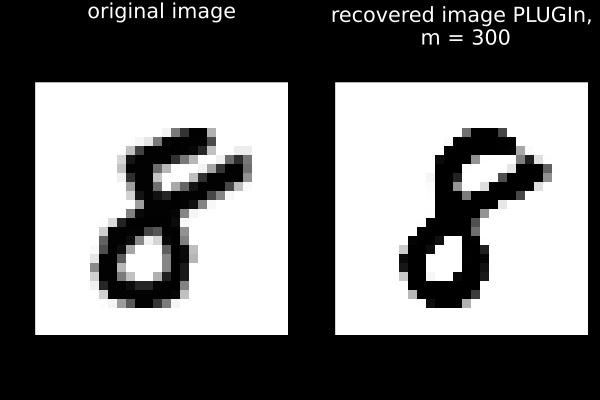

In [87]:
# experiments with MNIST dataset
function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

epoch_to_load = 20
# Load the model and test set loader
encoder_mu, encoder_logvar, decoder = load_model("result/MNIST", epoch_to_load)

# pick a image in MNIST to denoise
num = 8
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x = x_batch[:,i]
# x = decoder(z_est_PLUGIn)

noise_level = .1

m = 300; A = randn(m, 784)/sqrt(m)

# m = 784; A = I(m)

y = A*x + noise_level * randn(m)

stepsize_PLUGIn = 1
tolerance = 1e-7
max_iter = 1000


(_, z_dim) = size(Flux.params(decoder[1])[1]);
W = I(z_dim)

#normalize the weights of the network
for i in 1:length(decoder)
    _, s, _ = svd(Flux.params(decoder[i])[1])
    W = Flux.params(decoder[i])[1] * W /s[1]
end

z_est_PLUGIn = randn(z_dim)
for iter in 1:max_iter
    z_est_PLUGIn = PLUGIN_denoise(decoder, W, A, y, z_est_PLUGIn, stepsize_PLUGIn)
end


error = norm(x - decoder(z_est_PLUGIn))
println("reconstruction error: $error")

# z_rec_GD = GD_CS(decoder, y, A, max_iter, stepsize, tolerance, out_toggle)

recovered_image_PLUGIn = colorview(Gray, reshape(decoder(z_est_PLUGIn), 28,28)' )
# recovered_image_GD = colorview(Gray, reshape(decoder(z_rec_GD), 28,28)' )

true_image = colorview(Gray, reshape(x, 28,28)' );
p1 = plot(true_image, framestyle = :none, bg =:black, title = "original image")
p2 = plot(recovered_image_PLUGIn, framestyle = :none, bg =:black, title = "recovered image PLUGIn,\n m = $m")
# p3 = plot(recovered_image_GD, framestyle = :none, bg =:black, title = "recovered image GD,\n m = $m")
plot(p1, p2, layout = 2)




In [89]:
z_true = z_est_PLUGIn;
z_norm  = norm(z_est_PLUGIn)
x = decoder(z_true);

In [27]:
#########  SNR  #################
max_iter = 1000
stepsize_PLUGIn = .5
stepsize_GD = .5
noise_level_list = 0:.2:1

m = 300
(_, z_dim) = size(Flux.params(decoder[1])[1]);
W = I(z_dim)

#normalize the weights of the network
for i in 1:length(decoder)
    _, s, _ = svd(Flux.params(decoder[i])[1])
    W = Flux.params(decoder[i])[1] * W /s[1]
end

A = randn(m, 784) / sqrt(m)
recov_error_PLUGIn = []
recon_error_PLUGIn = []

recov_error_GD = []
recon_error_GD = []

recov_error_PLUGIn_proj = []
recon_error_PLUGIn_proj = []

recov_error_GD_proj = []
recon_error_GD_proj = []

recov_error_PLUGIn_reg = []
recon_error_PLUGIn_reg = []

recov_error_GD_reg = []
recon_error_GD_reg = []

recov_vector_PLUGIn = zeros(z_dim)
recov_vector_GD = zeros(z_dim)

for noise_level in noise_level_list

    noise_temp = randn(m)
    y = A*x + z_norm * noise_level * noise_temp/norm(noise_temp)

    descent(z) = gradient(z->norm(A*decoder(z) - y,2)^2, z)[1] 
    descent_regularized(z, λ) = gradient(z->norm(A*decoder(z) - y,2)^2 +λ*norm(z,2)^2, z)[1]        
  
    z_est_PLUGIn = randn(z_dim)
    z_est_GD = randn(z_dim)

    z_est_PLUGIn_proj = randn(z_dim)
    z_est_GD_proj = randn(z_dim)

    z_est_PLUGIn_reg = randn(z_dim)
    z_est_GD_reg = randn(z_dim)

    iter = 1
    for iter in 1:max_iter

        z_est_PLUGIn = PLUGIN_denoise(decoder, W, A, y, z_est_PLUGIn, stepsize_PLUGIn)
        d = descent(z_est_GD); z_est_GD -= stepsize_GD *d

        z_est_PLUGIn_proj = PLUGIN_denoise(decoder, W, A, y, z_est_PLUGIn_proj, stepsize_PLUGIn)
        z_est_PLUGIn_proj = proj(z_est_PLUGIn_proj, z_norm)

        d = descent(z_est_GD_proj); z_est_GD_proj -= stepsize_GD *d; z_est_GD_proj = proj(z_est_GD_proj, z_norm)

        z_est_PLUGIn_reg = PLUGIN_denoise_regularized(decoder, W, A, y, z_est_PLUGIn_reg, stepsize_PLUGIn, 0.05)

        d = descent_regularized(z_est_GD_reg, 0.05); z_est_GD_reg -= stepsize_GD *d
    end

    push!(recov_error_PLUGIn, relative_error(z_true, z_est_PLUGIn))
    push!(recon_error_PLUGIn,  relative_error(x, decoder(z_est_PLUGIn)) )

    push!(recov_error_GD, relative_error(z_true, z_est_GD))
    push!(recon_error_GD, relative_error(x, decoder(z_est_GD)) )  

    push!(recov_error_PLUGIn_proj, relative_error(z_true, z_est_PLUGIn_proj))
    push!(recon_error_PLUGIn_proj,  relative_error(x, decoder(z_est_PLUGIn_proj)) )

    push!(recov_error_GD_proj, relative_error(z_true, z_est_GD_proj))
    push!(recon_error_GD_proj, relative_error(x, decoder(z_est_GD_proj)) )  

    push!(recov_error_PLUGIn_reg, relative_error(z_true, z_est_PLUGIn_reg))
    push!(recon_error_PLUGIn_reg,  relative_error(x, decoder(z_est_PLUGIn_reg)) )

    push!(recov_error_GD_reg, relative_error(z_true, z_est_GD_reg))
    push!(recon_error_GD_reg, relative_error(x, decoder(z_est_GD_reg)) )  

    recov_vector_PLUGIn = hcat(recov_vector_PLUGIn, z_est_PLUGIn)
    recov_vector_GD = hcat(recov_vector_GD, z_est_GD)
    
end

# save("result/talk/CS_error_denoise_recov.jld", "error_GD", recov_error_matrix_GD, "error_PLUGIn", recov_error_matrix_PLUGIn, "error_GD_proj", recov_error_matrix_GD_proj, "error_PLUGIn_proj", recov_error_matrix_PLUGIn_proj, "error_GD_reg", recov_error_matrix_GD_reg, "error_PLUGIn_reg", recov_error_matrix_PLUGIn_reg)

# save("result/talk/CS_error_denoise_recon.jld", "error_GD", recon_error_matrix_GD, "error_PLUGIn", recon_error_matrix_PLUGIn, "error_GD_proj", recon_error_matrix_GD_proj, "error_PLUGIn_proj", recon_error_matrix_PLUGIn_proj, "error_GD_reg", recon_error_matrix_GD_reg, "error_PLUGIn_reg", recon_error_matrix_PLUGIn_reg)


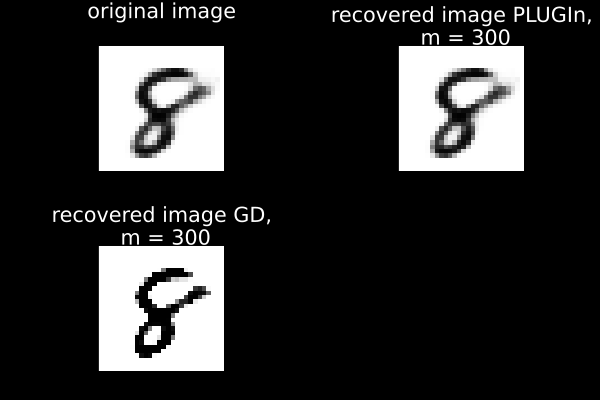

In [41]:
noise_level = 0
m = 300; A = randn(m, 784)/sqrt(m)

y = A*x + noise_level * randn(m)

stepsize_PLUGIn = 1
tolerance = 1e-7
max_iter = 1000

(_, z_dim) = size(Flux.params(decoder[1])[1]);
W = I(z_dim)

#normalize the weights of the network
for i in 1:length(decoder)
    _, s, _ = svd(Flux.params(decoder[i])[1])
    W = Flux.params(decoder[i])[1] * W /s[1]
end

z_est_PLUGIn = randn(z_dim)
z_est_GD = randn(z_dim)
descent(z) = gradient(z->norm(A*decoder(z) - y,2)^2, z)[1] 
for iter in 1:max_iter
    z_est_PLUGIn = PLUGIN_denoise(decoder, W, A, y, z_est_PLUGIn, stepsize_PLUGIn)
    d = descent(z_est_GD); z_est_GD -= stepsize_GD *d

end

recovered_image_PLUGIn = colorview(Gray, reshape(decoder(z_est_PLUGIn), 28,28)' )
recovered_image_GD = colorview(Gray, reshape(decoder(z_est_GD), 28,28)' )

original = colorview(Gray, reshape(x, 28,28)' )

p1 = plot(original, framestyle = :none, bg =:black, title = "original image")
p2 = plot(recovered_image_PLUGIn, framestyle = :none, bg =:black, title = "recovered image PLUGIn,\n m = $m")
p3 = plot(recovered_image_GD, framestyle = :none, bg =:black, title = "recovered image GD,\n m = $m")

plot(p1, p2, p3, layout = 3)


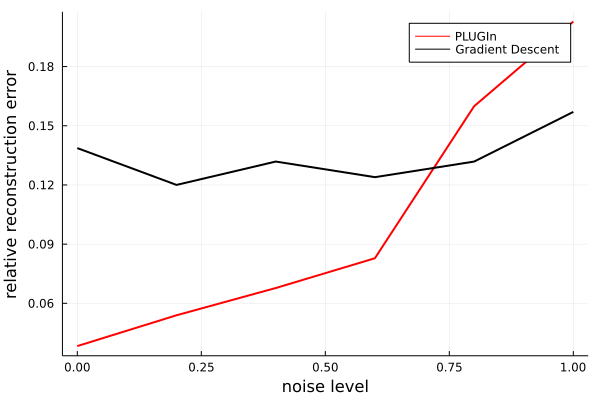

In [36]:
plot(noise_level_list, recon_error_PLUGIn, label = "PLUGIn", xlabel = "relative noise level", ylabel = "relative reconstruction error", linewidth = 2, color =:red)
plot!(noise_level_list, recon_error_GD, label = "Gradient Descent", xlabel = "noise level", ylabel = "relative reconstruction error", linewidth = 2, color =:black)


# plot(p1, p2, layout = (1,2))

# savefig("result/talk/CS_results/CS_original_noise_high_ratio.pdf")
# plot(p1, p2, layout = (1,2))


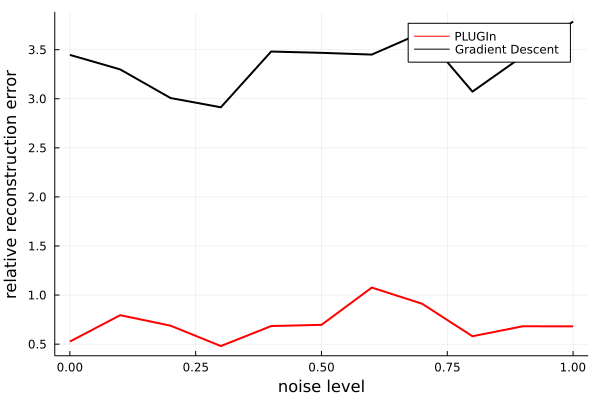

In [135]:
plot(noise_level_list, recov_error_PLUGIn, label = "PLUGIn", xlabel = "relative noise level", ylabel = "relative recovstruction error", linewidth = 2, color =:red)
plot!(noise_level_list, recov_error_GD, label = "Gradient Descent", xlabel = "noise level", ylabel = "relative reconstruction error", linewidth = 2, color =:black)

In [42]:
############ MEASUREMENTS ###############
max_iter = 1200
stepsize_PLUGIn = .75
noise_level_list = 0:.02:.12
trials = 10

m_list = 80:10:550

recov_error_matrix_PLUGIn_0 = zeros(length(m_list))
recon_error_matrix_PLUGIn_0 = zeros(length(m_list))

recov_error_matrix_PLUGIn_2 = zeros(length(m_list))
recon_error_matrix_PLUGIn_2 = zeros(length(m_list))

recov_error_matrix_PLUGIn_4 = zeros(length(m_list))
recon_error_matrix_PLUGIn_4 = zeros(length(m_list))

recov_error_matrix_PLUGIn_6 = zeros(length(m_list))
recon_error_matrix_PLUGIn_6 = zeros(length(m_list))

recov_error_matrix_PLUGIn_8 = zeros(length(m_list))
recon_error_matrix_PLUGIn_8 = zeros(length(m_list))

recov_error_matrix_PLUGIn_10 = zeros(length(m_list))
recon_error_matrix_PLUGIn_10 = zeros(length(m_list))

(_, z_dim) = size(Flux.params(decoder[1])[1]);
W = I(z_dim)

#normalize the weights of the network
for i in 1:length(decoder)
    _, s, _ = svd(Flux.params(decoder[i])[1])
    W = Flux.params(decoder[i])[1] * W /s[1]
end


noise_level = 0
for trial in 1:trials
 
    recov_error_PLUGIn_0 = []
    recon_error_PLUGIn_0 = []

    recov_error_PLUGIn_2 = []
    recon_error_PLUGIn_2 = []

    recov_error_PLUGIn_4 = []
    recon_error_PLUGIn_4 = []

    recov_error_PLUGIn_6 = []
    recon_error_PLUGIn_6 = []

    recov_error_PLUGIn_8 = []
    recon_error_PLUGIn_8 = []

    recov_error_PLUGIn_10 = []
    recon_error_PLUGIn_10 = []

    z = randn(z_dim)
    z = z/norm(z) #unit sphere

    for m in m_list
        noise_temp = randn(m)

        A = randn(m, 784) / sqrt(m)


        y0 = A*x + z_norm * noise_level_list[1] * noise_temp/norm(noise_temp)
        y2 = A*x + z_norm * noise_level_list[2] * noise_temp/norm(noise_temp)
        y4 = A*x + z_norm * noise_level_list[3] * noise_temp/norm(noise_temp)
        y6 = A*x + z_norm * noise_level_list[4] * noise_temp/norm(noise_temp)
        y8 = A*x + z_norm * noise_level_list[5] * noise_temp/norm(noise_temp)
        y10 = A*x + z_norm * noise_level_list[6] * noise_temp/norm(noise_temp)


        z_est_PLUGIn_0 = randn(z_dim)
        z_est_PLUGIn_2 = randn(z_dim)
        z_est_PLUGIn_4 = randn(z_dim)
        z_est_PLUGIn_6 = randn(z_dim)
        z_est_PLUGIn_8 = randn(z_dim)
        z_est_PLUGIn_10 = randn(z_dim)

        iter = 1
        for iter in 1:max_iter
            z_est_PLUGIn_0 = PLUGIN_denoise(decoder, W, A, y0, z_est_PLUGIn_0, stepsize_PLUGIn)
            z_est_PLUGIn_2 = PLUGIN_denoise(decoder, W, A, y2, z_est_PLUGIn_2, stepsize_PLUGIn)
            z_est_PLUGIn_4 = PLUGIN_denoise(decoder, W, A, y4, z_est_PLUGIn_4, stepsize_PLUGIn)
            z_est_PLUGIn_6 = PLUGIN_denoise(decoder, W, A, y6, z_est_PLUGIn_6, stepsize_PLUGIn)
            z_est_PLUGIn_8 = PLUGIN_denoise(decoder, W, A, y8, z_est_PLUGIn_8, stepsize_PLUGIn)
            z_est_PLUGIn_10 = PLUGIN_denoise(decoder, W, A, y10, z_est_PLUGIn_10, stepsize_PLUGIn)
        end
 
        push!(recov_error_PLUGIn_0, relative_error(z_true, z_est_PLUGIn_0))
        push!(recon_error_PLUGIn_0,  relative_error(x, decoder(z_est_PLUGIn_0)) )

        push!(recov_error_PLUGIn_2, relative_error(z_true, z_est_PLUGIn_2))
        push!(recon_error_PLUGIn_2,  relative_error(x, decoder(z_est_PLUGIn_2)) )

        push!(recov_error_PLUGIn_4, relative_error(z_true, z_est_PLUGIn_4))
        push!(recon_error_PLUGIn_4,  relative_error(x, decoder(z_est_PLUGIn_4)) )

        push!(recov_error_PLUGIn_6, relative_error(z_true, z_est_PLUGIn_6))
        push!(recon_error_PLUGIn_6,  relative_error(x, decoder(z_est_PLUGIn_6)) )

        push!(recov_error_PLUGIn_8, relative_error(z_true, z_est_PLUGIn_8))
        push!(recon_error_PLUGIn_8,  relative_error(x, decoder(z_est_PLUGIn_8)) )

        push!(recov_error_PLUGIn_10, relative_error(z_true, z_est_PLUGIn_10))
        push!(recon_error_PLUGIn_10,  relative_error(x, decoder(z_est_PLUGIn_10)) )
    end

    recov_error_matrix_PLUGIn_0 = hcat(recov_error_matrix_PLUGIn_0, recov_error_PLUGIn_0)
    recon_error_matrix_PLUGIn_0 =  hcat(recon_error_matrix_PLUGIn_0, recon_error_PLUGIn_0)

    recov_error_matrix_PLUGIn_2 = hcat(recov_error_matrix_PLUGIn_2, recov_error_PLUGIn_2)
    recon_error_matrix_PLUGIn_2 =  hcat(recon_error_matrix_PLUGIn_2, recon_error_PLUGIn_2)

    recov_error_matrix_PLUGIn_4 = hcat(recov_error_matrix_PLUGIn_4, recov_error_PLUGIn_4)
    recon_error_matrix_PLUGIn_4 =  hcat(recon_error_matrix_PLUGIn_4, recon_error_PLUGIn_4)

    recov_error_matrix_PLUGIn_6 = hcat(recov_error_matrix_PLUGIn_6, recov_error_PLUGIn_6)
    recon_error_matrix_PLUGIn_6 =  hcat(recon_error_matrix_PLUGIn_6, recon_error_PLUGIn_6)

    recov_error_matrix_PLUGIn_8 = hcat(recov_error_matrix_PLUGIn_8, recov_error_PLUGIn_8)
    recon_error_matrix_PLUGIn_8 =  hcat(recon_error_matrix_PLUGIn_8, recon_error_PLUGIn_8)

    recov_error_matrix_PLUGIn_10 = hcat(recov_error_matrix_PLUGIn_10, recov_error_PLUGIn_10)
    recon_error_matrix_PLUGIn_10 =  hcat(recon_error_matrix_PLUGIn_10, recon_error_PLUGIn_10)
end

In [63]:
cs = palette([:red,  :orange, :green, :blue, :Indigo], 1000)

average_recon = mean(recon_error_matrix_PLUGIn_10[:, 2:end], dims=2)
plot(m_list, average_recon, label = "relative noise = 0.1", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1000], xaxis =:log, yaxis=:log)

# average_recon = mean(recon_error_matrix_PLUGIn_8[:, 2:end], dims=2)
# plot!(m_list, average_recon, label = "relative noise = 0.08", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[800])

average_recon = mean(recon_error_matrix_PLUGIn_6[:, 2:end], dims=2)
plot!(m_list, average_recon, label = "relative noise = 0.06", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[600])

# average_recon = mean(recon_error_matrix_PLUGIn_4[:, 2:end], dims=2)
# plot!(m_list, average_recon, label = "relative noise = .04", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[400])

# average_recon = mean(recon_error_matrix_PLUGIn_2[:, 2:end], dims=2)
# plot!(m_list, average_recon, label = "relative noise = .02", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[200])

average_recon = mean(max.(recon_error_matrix_PLUGIn_0[:, 2:end], 1e-4), dims=2)
p1 = plot!(m_list, average_recon, label = "relative noise = 0", xlabel = "measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1])

plot(p1, ylim = (10^(-1.5), 10^(-.5)))

savefig("result/talk/CS_PLUGIn_GD_measurement_recon_MNIST.pdf")

